<a href="https://colab.research.google.com/github/yoe174/Pembelajaran-Mesin_27_3C/blob/main/JS10_ML_Yonatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Jobsheet 10 : Recurrent Neural Network (RNN)**

Nama : Yonatan Efrassetyo - 27

Kelas : TI-3C

## Praktikum 1

### Setup

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [8]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [9]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [10]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [11]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"The emotional impact of this movie defies words. It is elegant, subtle, beautiful, and tragic all rolled into two hours. This is Will Smith as he matures into his acting ability, the full range of it. Who knew? I saw The Pursuit of Happiness and thought, this must be a fluke for the blockbuster, over-the-top actor, Smith. His performances in both movies portray a whole other dimension to Smith, a refinement of talent, the selectivity of scripts, I'm not sure, but I view him differently now. Seven Pounds is one of those movies that in order to fully enjoy its essence you have to suspend your belief. Don't watch it for the plot, watch it for the fragile condition of the human heart, both literally and metaphorically. It is a story of human guilt, atonement, love, and sacrifice."
 b"Brief summary: This movie demeans everyone it touches. That means you.<br /><br />First off, let me say I'm not a purist, and this might have been funny for a few minutes. The impersonations are not

### Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [14]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [15]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):


In [16]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  2, 891,   1, ...,   0,   0,   0],
       [  1,   1,  11, ...,   0,   0,   0],
       [ 10, 103,   2, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [17]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"The emotional impact of this movie defies words. It is elegant, subtle, beautiful, and tragic all rolled into two hours. This is Will Smith as he matures into his acting ability, the full range of it. Who knew? I saw The Pursuit of Happiness and thought, this must be a fluke for the blockbuster, over-the-top actor, Smith. His performances in both movies portray a whole other dimension to Smith, a refinement of talent, the selectivity of scripts, I'm not sure, but I view him differently now. Seven Pounds is one of those movies that in order to fully enjoy its essence you have to suspend your belief. Don't watch it for the plot, watch it for the fragile condition of the human heart, both literally and metaphorically. It is a story of human guilt, atonement, love, and sacrifice."
Round-trip:  the emotional [UNK] of this movie [UNK] words it is [UNK] [UNK] beautiful and [UNK] all [UNK] into two hours this is will [UNK] as he [UNK] into his acting [UNK] the full [UNK] of it who

### Buat Model

diagram model dapat dilihat pada gambar diatas

Model ini dapat dibuat sebagai tf.keras.Sequential.

 Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.

Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.

Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.

Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.

-Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.

-Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.

Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [18]:
# Membuat model Sequential
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [19]:
# Cek apakah setiap layer mendukung masking
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [20]:
# Prediksi pada teks sampel tanpa padding
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
encoded_sample = encoder(tf.constant([sample_text]))  # Encode dengan tf.constant

Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [21]:
# Contoh prediksi dengan padding
padding = "the " * 2000
sample_texts = [sample_text, padding]

# Menggunakan tf.constant untuk memastikan kompatibilitas
predictions = model.predict(tf.constant(sample_texts))
print(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.00516809]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.5146 - loss: 0.6814 - val_accuracy: 0.7552 - val_loss: 0.5518
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.7760 - loss: 0.4738 - val_accuracy: 0.8411 - val_loss: 0.3827
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.8392 - loss: 0.3732 - val_accuracy: 0.8568 - val_loss: 0.3536
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.8520 - loss: 0.3399 - val_accuracy: 0.8500 - val_loss: 0.3376
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.8599 - loss: 0.3227 - val_accuracy: 0.8510 - val_loss: 0.3218
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.8653 - loss: 0.3162 - val_accuracy: 0.8490 - val_loss: 0.3278
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.8638 - loss: 0.3183 - val_accuracy: 0.8604 - val_loss: 0.3082
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.8729 - loss: 0.2995 - 

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8573 - loss: 0.3154
Test Loss: 0.315228670835495
Test Accuracy: 0.8565999865531921


(0.0, 0.6614943966269493)

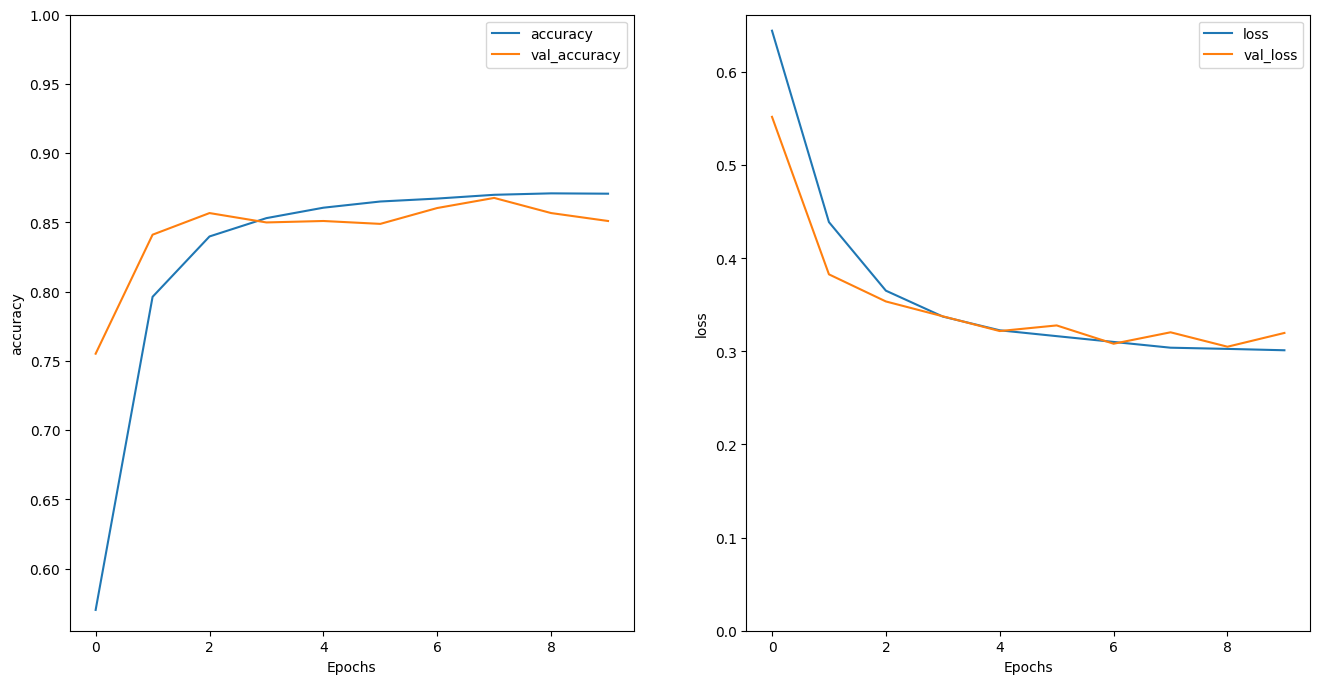

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [26]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Pastikan input berbentuk tensor agar kompatibel dengan model
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
[0.8631343]


### Stack two or more LSTM layers

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.

Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [27]:
model = tf.keras.Sequential([
     encoder,
     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(1)
])

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 115ms/step - accuracy: 0.5179 - loss: 0.6770 - val_accuracy: 0.7547 - val_loss: 0.4615
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.8194 - loss: 0.4022 - val_accuracy: 0.8411 - val_loss: 0.3311
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 108ms/step - accuracy: 0.8542 - loss: 0.3360 - val_accuracy: 0.8286 - val_loss: 0.3513
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.8598 - loss: 0.3297 - val_accuracy: 0.8547 - val_loss: 0.3426
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.8653 - loss: 0.3115 - val_accuracy: 0.8609 - val_loss: 0.3162
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.8675 - loss: 0.3091 - val_accuracy: 0.8505 - val_loss: 0.3255
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.8621 - loss: 0.3149 - val_accuracy: 0.8625 - val_loss: 0.3017
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.8715 - loss: 0

In [30]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8388 - loss: 0.3303
Test Loss: 0.3304831385612488
Test Accuracy: 0.8384799957275391


In [39]:
# Assuming 'encoder' is the TextVectorization layer used during training
sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
# Convert the sample text to a numerical representation using the encoder
encoded_sample_text = encoder(np.array([sample_text]))
predictions = model.predict(encoded_sample_text)
print(predictions)

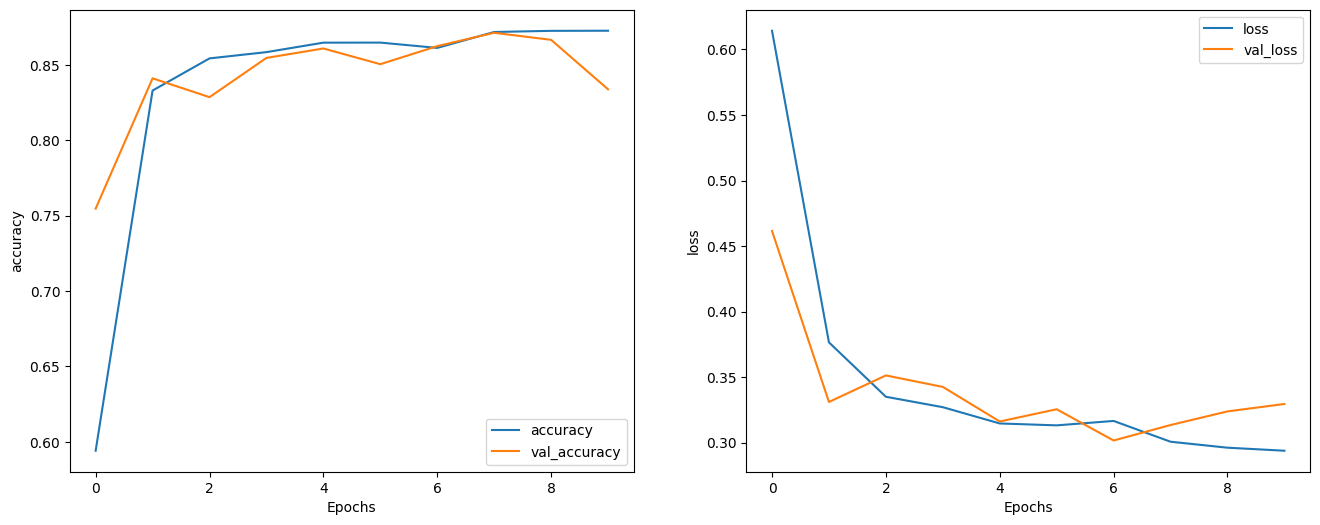

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## Praktikum 2

### Setup
Import TensorFlow

In [39]:
import tensorflow as tf
import numpy as np
import os
import time

In [40]:
!pip install tf-keras

In [41]:
import tf_keras as keras

### Download Dataset Shakespeare

Sesuaikan dengan lokasi data yang Anda punya.

In [63]:
path_to_file = keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

### Load Data

In [43]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### Olah Teks

Vectorize Teks

Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [6]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [7]:
ids_from_chars  =tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [8]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode tf.keras.layers.StringLookup(..., invert=True).

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode get_vocabulary() dari tf.keras.layers.StringLookup sehingga token [UNK] disetel dengan cara yang sama.

In [9]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:


In [10]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [11]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [12]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?

Membuat Trianing Set dan Target

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian seq_length+1. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [13]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [14]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [15]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [16]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [17]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [18]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [19]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [20]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [21]:
dataset = sequences.map(split_input_target)

In [22]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Membuat Batch Training

[teks link](https://)
Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [23]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### Buat Model

Bagian ini mendefinisikan model sebagai subkelas keras.Model (untuk lebih detilnya, lihat Making new Layers and Models via subclassing).

Model yang kita bangun memiliki 3 lapisan neural network :

tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;

tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)

tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [24]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [44]:
class MyModel(keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [45]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Untuk setiap karakter, model mencari penyematan, menjalankan GRU satu langkah waktu dengan penyematan sebagai masukan, dan menerapkan dense layer untuk menghasilkan log yang memprediksi kemungkinan log karakter berikutnya:

Note: Untuk pelatihan Anda bisa menggunakan model keras.Sequential di sini. Untuk menghasilkan teks nanti, Anda harus mengelola status internal RNN. Akan lebih mudah untuk memasukkan opsi input dan output status di awal, daripada mengatur ulang arsitektur model nanti. untuk detailnya bisa dilihat Keras RNN guide.

### Uji Model

Coba jalankan model dan cek apakah sidah sesuai dengan output

pertama, cek bentuk dari output

In [46]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


Dalam contoh di atas, panjang urutan masukan adalah 100 tetapi model dapat dijalankan pada masukan dengan panjang berapa pun:

In [47]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Untuk mendapatkan prediksi aktual dari model, Anda perlu mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter. Catatan: Penting untuk mengambil sampel dari distribusi ini karena mengambil argmax dari distribusi tersebut dapat dengan mudah membuat model terjebak dalam infinote loop. Cobalah untuk contoh pertama di batch:

In [48]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:

In [49]:
sampled_indices

array([10, 42,  5, 50,  4, 39, 45, 42, 12, 63, 62, 27, 28, 10, 13, 39, 39,
       64, 35, 30, 22, 61, 62, 47, 39, 48, 23, 58, 60, 10, 49, 13, 43, 46,
       31, 65, 49, 11, 42,  2, 52,  4, 62, 56, 48, 62,  6,  9, 63, 42, 24,
       27,  3, 33, 25, 11, 16, 50,  2, 18, 30, 28,  7,  3, 61, 15, 65, 18,
       57, 61, 12, 57,  9, 53, 18, 30, 18, 42,  8,  4, 46,  1,  9, 48, 57,
       53,  5, 60, 40, 16,  4, 42, 43,  4,  4, 40, 58, 46, 47, 40])

Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:

In [50]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"have frown'd on me;\nDukes, earls, lords, gentlemen; indeed, of all.\nI do not know that Englishman al"

Next Char Predictions:
 b"3c&k$Zfc;xwNO3?ZZyVQIvwhZiJsu3j?dgRzj:c m$wqiw'.xcKN!TL:Ck EQO,!vBzErv;r.nEQEc-$g\n.irn&uaC$cd$$asgha"


### Train Model

Pada titik ini permasalahan dapat dianggap sebagai permasalahan klasifikasi standar. Permasalahan dapat disimpulkan dengan : Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.

Tambahan optimizer dan fungsi loss
loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.

In [51]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [52]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1895666, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:

In [53]:
tf.exp(example_batch_mean_loss).numpy()

65.99419

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [54]:
model.compile(optimizer='adam', loss=loss)

Konfigurasi Checkpoints

Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [55]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training
Agar waktu pelatihan tidak terlalu lama, gunakan 10 epoch untuk melatih model. Di Colab, setel runtime ke GPU untuk pelatihan yang lebih cepat.

In [56]:
EPOCHS = 20

In [57]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 19s 56ms/step - loss: 2.7137
Epoch 2/20
172/172 [==============================] - 12s 56ms/step - loss: 1.9889
Epoch 3/20
172/172 [==============================] - 13s 60ms/step - loss: 1.7076
Epoch 4/20
172/172 [==============================] - 12s 59ms/step - loss: 1.5460
Epoch 5/20
172/172 [==============================] - 12s 61ms/step - loss: 1.4463
Epoch 6/20
172/172 [==============================] - 13s 62ms/step - loss: 1.3770
Epoch 7/20
172/172 [==============================] - 14s 59ms/step - loss: 1.3239
Epoch 8/20
172/172 [==============================] - 13s 61ms/step - loss: 1.2788
Epoch 9/20
172/172 [==============================] - 13s 61ms/step - loss: 1.2369
Epoch 10/20
172/172 [==============================] - 12s 60ms/step - loss: 1.1972
Epoch 11/20
172/172 [==============================] - 12s 61ms/step - loss: 1.1557
Epoch 12/20
172/172 [==============================] - 12s 61ms/step - loss: 1.1152
E

### Generate Teks

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.

Setiap kali Anda memanggil model, Anda memasukkan beberapa teks dan state internal. Model mengembalikan prediksi untuk karakter berikutnya dan state barunya. Masukkan kembali prediksi dan state ke model untuk terus menghasilkan teks.

Berikut ini membuat prediksi satu langkah:

In [58]:
class OneStep(keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [59]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [60]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
The king's offence, if it be done.

PRINCE EDWARD:
For me to Brittany; now then be dead,
Yet nature stifts his son a great king's deef-bed,
Was sent for to your tender o'er my reside.

GONZALO:
No,
Ne'er be so stronger, shed from this service.

BAPTISTA:
How long is't so, untir Tybalt's son deflexing answer's;
And most it came so musty Isabel.

GREY:
God save you, Mariana, Lucarous.

GLOUCESTER:
My sovereign liege, my lord, will you to die not
Caiuse-heady good one friend to thee,
What comfort I to crucket him to me fruit.

KING LEWIS XI:
What, wilt thou think, I see, thou must be malige on.

Lord:
O master, what news?

BENVOLIO:
Good morrow, sweet way: O! That we say, 'What did
Can Denour is mine office, friend!

CLEOMENES:
Young bod, that haste disposed them stirral lords:
No man, she's die for numper, stay year men,
And rap the gates of Norfolk, Ratchman:'

Prodds
Ye reagled, it's heir of Blotations:
By a divined perious instruments:
The general is our Romeo?

ROMEO:
Tut, go,

Hal termudah yang dapat Anda lakukan untuk meningkatkan hasil adalah dengan melatihnya lebih lama (coba EPOCHS = 30). Anda juga dapat bereksperimen dengan string awal yang berbeda, mencoba menambahkan lapisan RNN lain untuk meningkatkan akurasi model, atau menyesuaikan parameter suhu untuk menghasilkan prediksi yang kurang lebih acak.

Jika Anda ingin model menghasilkan teks lebih cepat, hal termudah yang dapat Anda lakukan adalah membuat teks secara batch. Pada contoh di bawah, model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.

In [61]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nShe shall become the day; and thank you for our head.\n\nDUKE VINCENTIO:\nO, sir, you life, if it be true! that's the matter.\n\nMARCIUS:\nNay, but have wretched the boar.\nFarewell, my noble lords, be money of my thought:\nFor him now, you, good night is donf; thy sleep\nTo think upon the slave of heaven and banquet\nbails their elump, he would began their pleasure he\nhath in your man's time of death no man.\n\nDUKE VINCENTIO:\nYou art the saluteous nurse, so wetch no less than it,\nPartoning the which yellow out the way.\n\nCAMILLO:\nI'll be a prophetest.\n\nDUKE VINCENTIO:\nAh, my hearts! my master good Lord Grey, of all the world:\nHe doth not look on foot which finds am nour\na king: we are the water to my wife, if he\nAy, a strange loid, before this death, I digh with speed\nto thank you of:\nIf thy young voice is in your word. Come all alone,\nCome two sextenders out, or I with deadly mouth,\nGo renew my thumper'd joys, so althrice rough shall.\n\nKING EDW

### Ekspor Model Generator

Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun tf.saved_model diterima.

In [62]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')